# Pokemon Classification

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124


In [2]:
import os
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models 
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import pickle
import torch.optim as optim

In [3]:

class TransformSubset(Dataset):
    """
    Wrapper for applying transformations to a Subset.
    """
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)


In [4]:
class PokemonDataModule(Dataset):
    def __init__(self, data_dir):
        self.dataset = ImageFolder(root=data_dir)
        self.class_names = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def plot_examples(self, dataloader, n_rows=1, n_cols=4, stats=None):
        """
        Plot examples from a DataLoader.
    
        Args:
            dataloader (DataLoader): DataLoader object to fetch images and labels from.
            n_rows (int): Number of rows in the plot grid.
            n_cols (int): Number of columns in the plot grid.
            denormalize (callable, optional): Function to reverse normalization for visualization. 
                                              Should accept a tensor and return a denormalized tensor.
        """
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
        axes = axes.flatten()  # Flatten to iterate easily
    
        # Iterate over the dataloader to get a batch of data
        for data, labels in dataloader:
            # Take the first n_rows * n_cols samples from the batch
            for i, ax in enumerate(axes[:n_rows * n_cols]):
                if i >= len(data):  # If fewer samples than the grid size, stop
                    break
                
                img, label = data[i], labels[i]
    
                # Apply denormalization if provided
                if stats:
                    img = self._denormalize(img, stats)
                
                # Convert CHW to HWC for plotting
                img = img.permute(1, 2, 0).cpu().numpy()
    
                ax.imshow(img)
                ax.set_title(self.class_names[label.item()])
                ax.axis('off')
            break  # Only process the first batch
    
        plt.tight_layout()
        plt.show()

    def _denormalize(self, img, stats):
        """
        Denormalize an image tensor.
    
        Args:
            img (Tensor): Image tensor with shape (C, H, W).
            stats (dict): Dictionary containing 'means' and 'stds' for each channel.
                          Example: {'means': [0.485, 0.456, 0.406], 'stds': [0.229, 0.224, 0.225]}.
    
        Returns:
            Tensor: Denormalized image tensor.
        """
        return img * stats['std'].view(-1, 1, 1) + stats['mean'].view(-1, 1, 1)

    def _get_stats(self, dataset):
        """
        Calculate the mean and standard deviation of the dataset for standardization.
        """
        dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)
        total_sum, total_squared_sum, total_count = 0, 0, 0
        with torch.cuda.device(0):
            for data, _ in dataloader:
                data.cuda()
                total_sum += data.sum(dim=(0, 2, 3))
                total_squared_sum += (data ** 2).sum(dim=(0, 2, 3))
                total_count += data.size(0) * data.size(2) * data.size(3)
    
            means = total_sum / total_count
            stds = torch.sqrt((total_squared_sum / total_count) - (means ** 2))
        return means, stds

    def prepare_data(self,
                     indices_file='indices.pkl',
                     get_stats=False
                    ):
        """
        Prepare train and test dataloaders with optional transformations.
        
        Args:
            indices_file (str): Path to save or load train/test indices.
            transform (callable): Primary transformation to apply to the data.
            additional_transforms (callable): Additional transformations to compose.
        
        Returns:
            tuple: trainloader, testloader
        """
        try:
            with open(indices_file, 'rb') as f:
                self.train_indices, self.test_indices = pickle.load(f)
        except (EOFError, FileNotFoundError):
            # Generate new indices if file is empty or doesn't exist
            self.train_indices, self.test_indices = train_test_split(
                range(len(self.dataset)),
                test_size=0.2,
                stratify=self.dataset.targets,
                random_state=42
            )
            
            # Ensure directory exists before saving
            os.makedirs(os.path.dirname(indices_file) or '.', exist_ok=True)
            
            with open(indices_file, 'wb') as f:
                pickle.dump([self.train_indices, self.test_indices], f)

        # Prepare train and test subsets
        self.train_dataset = Subset(self.dataset, self.train_indices)
        self.test_dataset = Subset(self.dataset, self.test_indices)
        
        return self._get_stats(self.train_dataset) if get_stats else None

    def get_dataloaders(self,
                    train_transform=None,
                    test_transform=None,
                    train_batch_size=None,
                    test_batch_size=None):
            """
            Prepare train and test dataloaders with optional transformations.
            
            Args:
                train_transform (callable): Transformation to apply to training data.
                train_batch_size (int): Batch size for the training dataloader.
                validation_batch_size (int): Batch size for the validation dataloader.
            
            Returns:
                tuple: trainloader, testloader
            """
            assert self.train_dataset is not None, "You need to call `prepare_data` before using `get_dataloaders`."
            
            # Default batch sizes if not provided
            test_batch_size = train_batch_size if test_batch_size is None else test_batch_size
            
            # Wrap subsets in a transformed dataset if transformations are provided
            train_dataset = TransformSubset(self.train_dataset, train_transform) if train_transform else self.train_dataset
            
            test_dataset = TransformSubset(self.test_dataset, test_transform) if test_transform else self.test_dataset
            
            trainloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
            testloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
            
            return trainloader, testloader


In [5]:
DATA_DIR = "/kaggle/input/pokemonclassification/PokemonData"
INDICIES_FILE = "/kaggle/input/pokindicies/indices.pkl"

pokemon_dataset = PokemonDataModule(DATA_DIR)
NUM_CLASSES = len(pokemon_dataset.class_names)

In [6]:
# Get class names
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 150


In [7]:
# You can only the use precomputed means and vars if using the same indices file ('indices.pkl')
chanel_means = torch.tensor([0.6062, 0.5889, 0.5550])
chanel_vars = torch.tensor([0.3284, 0.3115, 0.3266])
stats = {"mean":chanel_means, "std":chanel_vars}

pokemon_dataset.prepare_data(indices_file=INDICIES_FILE, get_stats=False)

In [8]:
print(f"Train dataset size: {len(pokemon_dataset.train_dataset)}")
print(f"Test dataset size: {len(pokemon_dataset.test_dataset)}")

Train dataset size: 5456
Test dataset size: 1364


In [9]:
IMG_SHAPE = ((224,224))

In [10]:
# Transformations of data for testing  
test_transform=transforms.Compose([
        transforms.Resize(IMG_SHAPE),
        transforms.ToTensor(),       # Convert PIL images to tensors
        transforms.Normalize(**stats), # Normalize images using mean and std

])

In [13]:
# Data augmentations for training 
train_transform = transforms.Compose([
    transforms.Resize(IMG_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SHAPE, padding=4),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(**stats)
])

In [22]:
# get dataloaders
trainloader, testloader= pokemon_dataset.get_dataloaders(train_transform=train_transform,
                                                         test_transform=test_transform,
                                                         train_batch_size=128,
                                                         test_batch_size=512
                                                        )

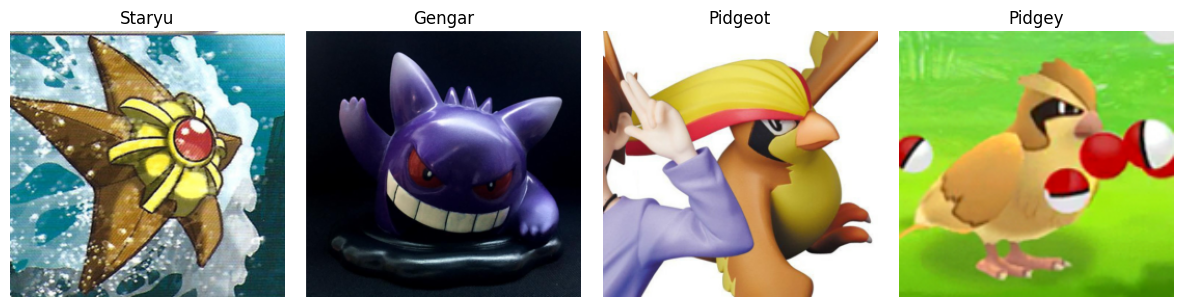

In [23]:
pokemon_dataset.plot_examples(testloader, stats=stats)

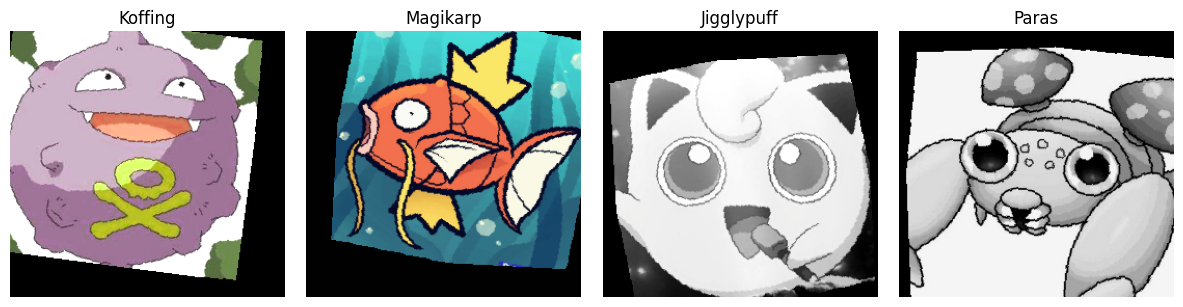

In [24]:
pokemon_dataset.plot_examples(trainloader, stats=stats)

In [25]:
# Define the training loop
def train_one_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(trainloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100.0 * correct / total
    return epoch_loss, epoch_accuracy

# Define the evaluation loop
@torch.no_grad()
def evaluate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(testloader, desc="Evaluating", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(testloader)
    epoch_accuracy = 100.0 * correct / total
    return epoch_loss, epoch_accuracy

# Define the pipeline
def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, device, epochs):
    """
    Train and evaluate the model.

    Args:
        model (nn.Module): The neural network model.
        trainloader (DataLoader): DataLoader for training data.
        testloader (DataLoader): DataLoader for test data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        device (torch.device): Device to train on ('cuda' or 'cpu').
        epochs (int): Number of epochs to train.

    Returns:
        dict: Training and evaluation statistics.
    """
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    model.to(device)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Train for one epoch
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

        # Evaluate the model
        test_loss, test_acc = evaluate(model, testloader, criterion, device)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

        # Save statistics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

    return history

In [31]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [34]:
def initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

MODELS = ["resnet", "alexnet", "vgg", "squeezenet", "densenet"]

# Try with a finetuning a resnet for example
model = initialize_model(MODELS[0],
                        NUM_CLASSES,
                        feature_extract=True,
                        use_pretrained=True)

In [35]:
# Print the model we just instantiated
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Model, criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train and evaluate
history = train_and_evaluate(
    model=model,
    trainloader=trainloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=10
)

Epoch 1/10


Training:  28%|██▊       | 12/43 [00:22<00:55,  1.77s/it]